In [105]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import scipy as sp
from scipy.sparse import kron, eye, diags
import math as mt

# **Excercise 3: Iterative Solvers in 2D**

## **Matrix-free 5-point Laplacian**

### **Matrix free multiplication: Amult**

In [106]:
def Amult(U):
    m = int(np.sqrt(len(U)))
    h = 1/(m+1)
    
    # Reshape U into a 2D array for easier indexing
    U = U.reshape((m, m), order='F')
    
    # Create expanded U to allow slicing
    expanded_U = np.zeros((m+2,m+2))
    expanded_U[1:-1,1:-1] = U
    
    # Initialize product array
    AU = np.zeros_like(U)
    
    # Stencil terms
    left_term   = expanded_U[1:-1, :-2]
    right_term  = expanded_U[1:-1, 2:]   
    bottom_term = expanded_U[:-2, 1:-1]  
    top_term    = expanded_U[2:, 1:-1]   
    self_term   = -4*U                 

    #Solution
    AU = (left_term+right_term+bottom_term+top_term+self_term)/h**2  
    
    return -AU.flatten('F')

### **Conjugate Gradient** : matrix-free

In [107]:
# Exact solution
def exact_solution(x, y):
    pi = np.pi
    # return 1+ 1*x
    return np.sin(4 * pi * (x + y)) + np.cos(4 * pi * x * y)

# Analytical solution for the Laplacian
def analytical_laplacian(x, y):
    pi = np.pi
    # return 0 + 0*x*y
    return -32 * pi**2 * np.sin(4 * pi * (x + y)) - 16 * pi**2 * (x**2 + y**2) * np.cos(4 * pi * x * y)

In [108]:
# Include BC in the right-hand side f (5-point Laplacian)
def f_BC_5p(f,u_exact):
    m = len(f) - 2
    h = 1/(m+1)
    # 5 point nodes coefficients
    main_coeff = 1/h**2
    # Left boundary
    f[1:m+1, 1] = f[1:m+1, 1] - main_coeff * u_exact[1:m+1, 0]
    # Right boundary
    f[1:m+1, m] = f[1:m+1, m] - main_coeff * u_exact[1:m+1, m+1]
    # Bottom boundary
    f[1, 1:m+1] = f[1, 1:m+1] - main_coeff * u_exact[0, 1:m+1]
    # Top boundary
    f[m, 1:m+1] = f[m, 1:m+1] - main_coeff * u_exact[m+1, 1:m+1]
    
    return f

In [109]:
# Mesh
m = 50
h = 1 / (m + 1)
x = np.linspace(0, 1, m+2)
y = np.linspace(0, 1, m+2)

X, Y = np.meshgrid(x, y)

# Compute exact solution and Laplacian
u_exact = exact_solution(X, Y)
exact_laplacian = analytical_laplacian(X, Y)

# Construct right-hand side (vectorized)
f = exact_laplacian.copy()

# Extract only the interior points
f_complete = f_BC_5p(f,u_exact) 
f = f_complete[1:-1, 1:-1]

# Construct the matrix A

# Flatten to match dimensionality
f_flatten = f.flatten('F')

# Solve system
u_app = np.ones(m**2)

# Track convergence history
# Callback function to compute and store the residual norm at each iteration (it returns the solution u_k)
residuals = []

def callback(u_k):
    r_k = f_flatten + A_operator.matvec(u_k)  # Correctly compute the residual using matvec()
    norm_residual = np.linalg.norm(r_k)  # Compute the residual norm
    residuals.append(norm_residual)  # Store it
    
A_operator = sp.sparse.linalg.LinearOperator((m**2, m**2), matvec=Amult)
u_app, _ = sp.sparse.linalg.cg(A_operator,-f_flatten, rtol=1e-8, callback=callback)

# Fill the full grid with computed values
U = u_exact.copy()
U[1:-1, 1:-1] = u_app.reshape((m, m), order='F')

# Compute error
error = np.abs(U - u_exact)

#### **Convergence History (CG)**

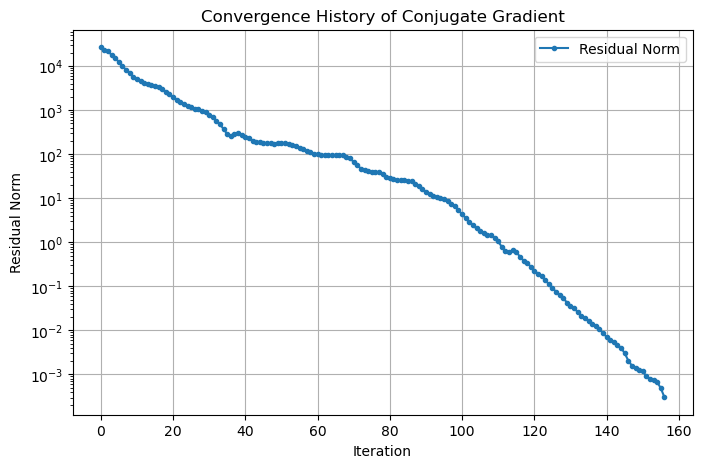

In [110]:
plt.figure(figsize=(8,5))
plt.semilogy(residuals, label="Residual Norm", marker='.')  # Log scale for clear decay
plt.xlabel("Iteration")
plt.ylabel("Residual Norm")
plt.title("Convergence History of Conjugate Gradient")
plt.legend()
plt.grid()
plt.show()

As we can observe in the plot, we achieve a almost linear convergence.

#### **Convergence Rate Estimate (CG)**

We have to check that the operator AU is symmetric

In [111]:
def symmetry_A_operator(A_operator):

    # Generate two random vectors
    x = np.random.rand(m**2)
    y = np.random.rand(m**2)

    # Compute Ax and Ay
    Ax = A_operator.matvec(x)
    Ay = A_operator.matvec(y)

    # Compute symmetry condition: x^T * (A y) vs. y^T * (A x)
    symmetry_error = np.abs(np.dot(x, Ay) - np.dot(y, Ax)) / np.abs(np.dot(x, Ay))

    # Print result
    print(f"Symmetry Error = {symmetry_error}")

    # Set a small threshold for numerical errors
    if symmetry_error < 1e-10:
        print("A is symmetric")
    else:
        print("A is not symmetric")


Estimate Convergence Rate for CG

In [112]:
from scipy.sparse.linalg import eigsh

number_iterations = len(residuals)

# Let's check if A is symmetric
symmetry_A_operator(A_operator)

# Compute the largest and smallest eigenvalues of A
lambda_max, _ = eigsh(A_operator, k=1, which='LM')
lambda_min, _ = eigsh(A_operator, k=1, which='SM')

# Condition number and convergence rate
kappa_A = lambda_max / lambda_min
rho_CG = (np.sqrt(kappa_A) - 1) / (np.sqrt(kappa_A) + 1)

print(f"Condition Number: {kappa_A[0]:.2e}")
print(rf"Theoretical Convergence Rate: $\rho = {rho_CG[0]:.4f}$")


Symmetry Error = 9.175663404176104e-16
A is symmetric
Condition Number: 1.05e+03
Theoretical Convergence Rate: $\rho = 0.9402$


## **Under/over-relaxed Jacobi smoothing**

### **Eigenvalues and $\omega_{opt}$**

The optimal w is 0.6733668341708543


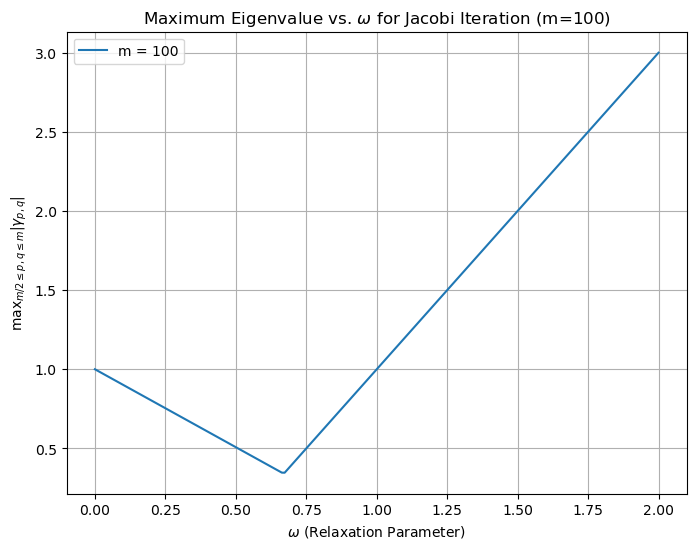

In [113]:
def compute_max_gamma(m, h, omega):
    
    gamma_max = 0
    for p in range(m // 2, m + 1):
        for q in range(m // 2, m + 1):
            # gamma_pq = 1 + omega/2 * (np.cos(p * np.pi * h) + np.cos(q * np.pi * h) - 1)
            gamma_pq = 1 - omega + omega/2 * (np.cos(p * np.pi * h) + np.cos(q * np.pi * h))
            gamma_max = max(gamma_max, abs(gamma_pq))
    return gamma_max

def underrelaxed_jacobi_eigenvalues(m):

    omega_vals = np.linspace(0, 2, 200)
    h = 1 / (m + 1)

    max_eigenvalues = [compute_max_gamma(m, h, omega) for omega in omega_vals]
    
    plt.figure(figsize=(8,6))
    plt.plot(omega_vals, max_eigenvalues, label=f'm = {m}')

    print(f'The optimal w is {omega_vals[np.argmin(max_eigenvalues)]}')
    
    plt.xlabel(r'$\omega$ (Relaxation Parameter)')
    plt.ylabel(r'max$_{m/2 \leq p,q \leq m} | \gamma_{p,q} |$')
    plt.title(rf'Maximum Eigenvalue vs. $\omega$ for Jacobi Iteration (m={m})')
    plt.legend()
    plt.grid()
    plt.show()

    return omega_vals[np.argmin(max_eigenvalues)]

# Example usage: Experiment with a specific value of m
w_opt = underrelaxed_jacobi_eigenvalues(100)

### **Matrix-free relaxed Jacobi**

Let's compute the function for the relaxed Jacobi method

In [114]:
def smooth(U,omega,F):

    # Initialize residuals
    residuals = []

    # Iteration parameters
    tolerance = 1e-8
    max_iterations = int(1e5)

    # Mesh size
    m = int(np.sqrt(len(U)))
    h = 1 / (m + 1)

    # Initial residual
    residuals.append(np.linalg.norm(F + Amult(U)))

    # Iteration
    for k in range(1,max_iterations):

        # Update the solution
        U_new = U + omega * h**2 /4 * ( -Amult(U) - F)

        # Calculate the residual
        residuals.append(np.linalg.norm(F + Amult(U)))

        # Stopping criterion
        if residuals[k]/residuals[0] < tolerance:
            print(f"Converged in {k+1} iterations with final residual {residuals[k]:.2e}")
            return U_new, residuals
            break
        
        U = U_new

    print(f"Converged in {k+1} iterations with final residual {residuals[k]:.2e}")
    return U, residuals

Full Solution Code:

In [115]:
# Mesh
m = 50
h = 1 / (m + 1)
x = np.linspace(0, 1, m+2)
y = np.linspace(0, 1, m+2)

X, Y = np.meshgrid(x, y)

# Compute exact solution and Laplacian
u_exact = exact_solution(X, Y)
exact_laplacian = analytical_laplacian(X, Y)

# Construct right-hand side (vectorized)
f = exact_laplacian.copy()

# Extract only the interior points
f_complete = f_BC_5p(f,u_exact) 
f = f_complete[1:-1, 1:-1]

# Construct the matrix A

# Flatten to match dimensionality
f_flatten = f.flatten('F')

# Solve system
u_app = np.zeros(m**2)

# Underrelaxed-Jacobi iteration
u_app, residuals = smooth(u_app, w_opt, f_flatten)

# Fill the full grid with computed values
U = u_exact.copy()
U[1:-1, 1:-1] = u_app.reshape((m, m), order='F')

# Compute error
error = np.abs(U - u_exact)

Converged in 9493 iterations with final residual 4.56e-04


As we observe, the more nodes we have in our grid, the more number of iterations the iterative method will need to get some established accuracy.

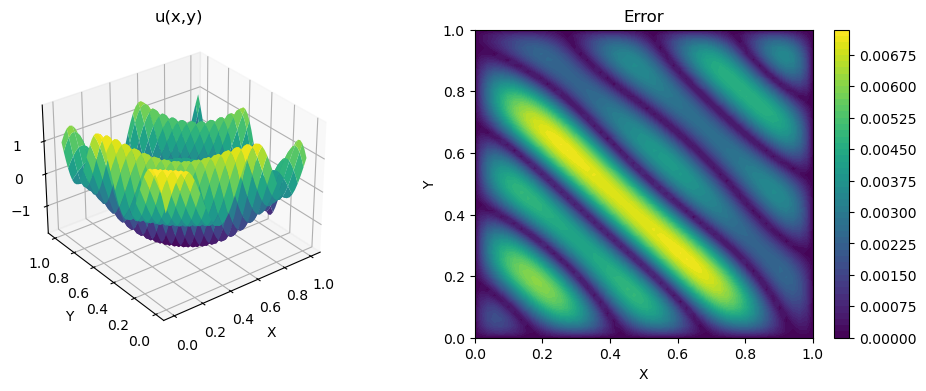

In [116]:
# Create figure with 2 columns
fig = plt.figure(figsize=(12, 4), dpi=100)
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1],wspace=0.2)

# ----- Subplot 1: 3D Surface Plot -----
ax1 = fig.add_subplot(gs[0], projection='3d')
ax1.plot_surface(X, Y, U, cmap='viridis')

# Reverse axes for MATLAB-like orientation
ax1.set_xlim(ax1.get_xlim()[::-1])  
ax1.set_ylim(ax1.get_ylim()[::-1])  

# Set view to match MATLAB
ax1.view_init(elev=30, azim=90-37.5)

# Labels
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('u(X,Y)')
ax1.set_title('u(x,y)')


# ----- Subplot 2: Contour Plot -----
ax2 = fig.add_subplot(gs[1])
contour = ax2.contourf(X, Y, error, levels=50, cmap='viridis')
fig.colorbar(contour, ax=ax2)  # Add colorbar
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('Error')

# Save figur
# fig.savefig('2b_c_Solution.png', bbox_inches='tight', dpi=200)

#plt.tight_layout()

plt.show()

Let's plot the residuals and check we have a linear convergence

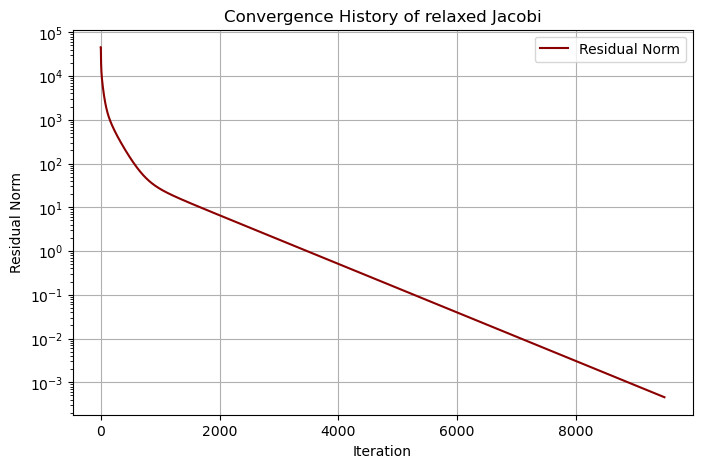

In [117]:
plt.figure(figsize=(8,5))
plt.semilogy(residuals, label="Residual Norm",color='darkred')  # Log scale for clear decay
plt.xlabel("Iteration")
plt.ylabel("Residual Norm")
plt.title("Convergence History of relaxed Jacobi")
plt.legend()
plt.grid()
plt.show()

## **Multigrid solver**

Exact Solution:

In [118]:
# Exact solution
def exact_solution(x, y):
    pi = np.pi
    # return 1+ 1*x
    return np.sin(4 * pi * (x + y)) + np.cos(4 * pi * x * y)

# Analytical solution for the Laplacian
def analytical_laplacian(x, y):
    pi = np.pi
    # return 0 + 0*x*y
    return -32 * pi**2 * np.sin(4 * pi * (x + y)) - 16 * pi**2 * (x**2 + y**2) * np.cos(4 * pi * x * y)

Right-hand side

In [119]:
# Include BC in the right-hand side f (5-point Laplacian)
def f_BC_5p(f,u_exact):
    m = len(f) - 2
    h = 1/(m+1)
    # 5 point nodes coefficients
    main_coeff = 1/h**2
    # Left boundary
    f[1:m+1, 1] = f[1:m+1, 1] - main_coeff * u_exact[1:m+1, 0]
    # Right boundary
    f[1:m+1, m] = f[1:m+1, m] - main_coeff * u_exact[1:m+1, m+1]
    # Bottom boundary
    f[1, 1:m+1] = f[1, 1:m+1] - main_coeff * u_exact[0, 1:m+1]
    # Top boundary
    f[m, 1:m+1] = f[m, 1:m+1] - main_coeff * u_exact[m+1, 1:m+1]
    
    return f

Matrix-free multiplication

In [120]:
def Amult(U):
    m = int(np.sqrt(len(U)))
    h = 1/(m+1)
    
    # Reshape U into a 2D array for easier indexing
    U = U.reshape((m, m), order='F')
    
    # Create expanded U to allow slicing
    expanded_U = np.zeros((m+2,m+2))
    expanded_U[1:-1,1:-1] = U
    
    # Initialize product array
    AU = np.zeros_like(U)
    
    # Stencil terms
    left_term   = expanded_U[1:-1, :-2]
    right_term  = expanded_U[1:-1, 2:]   
    bottom_term = expanded_U[:-2, 1:-1]  
    top_term    = expanded_U[2:, 1:-1]   
    self_term   = -4*U                 

    #Solution
    AU = (left_term+right_term+bottom_term+top_term+self_term)/h**2  
    
    return -AU.flatten('F')

Matrix Multiplication

In [121]:
# Under-relaxed Jacobi smoothing
def smooth(U,omega,nsmooth,F):

    # Initialize residuals
    residuals = []

    # Iteration parameters
    tolerance = 1e-8
    max_iterations = nsmooth

    # Mesh size
    m = int(np.sqrt(len(U)))
    h = 1 / (m + 1)

    # Initial residual
    residuals.append(np.linalg.norm(F + Amult(U)))

    # Iteration
    for k in range(1,max_iterations):

        # Update the solution
        U_new = U + omega * h**2 /4 * ( -Amult(U) - F)

        # Calculate the residual
        residuals.append(np.linalg.norm(F + Amult(U_new)))

        # Stopping criterion
        if residuals[k]/residuals[0] < tolerance:
            # print(f"Converged in {k+1} iterations with final residual {residuals[k]:.2e}")
            return U_new
            break
        
        U = U_new

    # print(f"Converged in {k+1} iterations with final residual {residuals[k]:.2e}")
    return U

Coarsen function:

In [122]:
# Coarsen function: fine grid to coarse grid
def coarsen(r):
    m = int(np.sqrt(len(r)))
    r = r.reshape((m, m), order='F')
    m_coarse = int((m - 1) / 2)
    
    # Direct Interpolation
    # r_coarse = r[1::2,1::2]      # Pick each two elements from the first one
    
    # Full-Weighting Interpolation
    r_coarse = (
        1/16 * r[0:-2:2, 0:-2:2] + 1/8 * r[1:-1:2, 0:-2:2] + 1/16 * r[2::2, 0:-2:2] +
        1/8  * r[0:-2:2, 1:-1:2] + 1/4  * r[1:-1:2, 1:-1:2] + 1/8  * r[2::2, 1:-1:2] +
        1/16 * r[0:-2:2, 2::2] + 1/8 * r[1:-1:2, 2::2] + 1/16 * r[2::2, 2::2]
    )
    
    return r_coarse.flatten('F')

Interpolate function:

In [123]:
# Interpolate function: coarse grid to fine grid
def interpolate(e_coarse,m):
    
    # Grid properties
    m_coarse = int(np.sqrt(len(e_coarse)))
    h_coarse = 1 / (m_coarse + 1)    
    
    # Reshape for convenience
    e_coarse = e_coarse.reshape((m_coarse, m_coarse), order='F')

    # Project back onto the fine grid
    # We add the boundary nodes for easier indexing
    e = np.zeros((m+2,m+2))
    e[2:-2:2,2:-2:2] = e_coarse

    # Interpolation
    
    # FIRST SWEEP: Horizontal
    e[2:-2:2, 1:-1:2] = 1/2 * (e[2:-2:2, 0:-1:2] + e[2:-2:2, 2::2])
    
    # SECOND SWEEP: Vertical
    e[1:-1:2, 2:-2:2] = 1/2 * (e[0:-1:2, 2:-2:2] + e[2::2, 2:-2:2])
    
    # THIRD SWEEP: bilinear interpolation
    e[1:-1:2, 1:-1:2] = 1/4 * (e[1:-1:2, 0:-2:2] + e[1:-1:2, 2::2] + e[0:-2:2, 1:-1:2] + e[2::2, 1:-1:2])
    
    # Get only the interior points back
    e = e[1:-1,1:-1]
        
    return e.flatten('F')

**VCycle**

In [124]:
# Recursive V-Cycle Solver
def Vcycle(U,omega,nsmooth,m,F):
    
    h = 1.0/(m+1)
    
    if m == 1:
        # We are at the coarsest level (1 node)
        
        # Create coarse grid matrix
        A_coarse = -4/(h**2)

        # Solve the coarse problem
        e_coarse = F/A_coarse
        
        U = e_coarse
        
    else:
        
        # 1. Pre-Smoothing
        U = smooth(U, omega, nsmooth, F)
        
        # 2. Compute Residual
        r = F + Amult(U)
        
        # 3. Coarsen Residual
        r_coarse = coarsen(r)
        
        # 4. Recurse to Vcycle
        mc = int(np.sqrt(len(r_coarse)))
        e_coarse = Vcycle(np.zeros_like(r_coarse), omega, nsmooth, mc, -r_coarse)
        
        # 5. Interpolate Error
        e = interpolate(e_coarse, m)
        
        # 6. Update Solution
        U -= e
        
        # 7. Post-Smoothing
        U = smooth(U, omega, nsmooth, F)    
    
    return U

The Vcycle must be run multiple times, until we obtain some tolerance.

In [125]:
def outer_iteration(U, m, F):

    epsilon = 1.0e-10
    max_iter = 100

    for i in range(1, max_iter + 1):
        R = F + Amult(U)  # Residual (note the sign: F - AhU = F + Amult(U, m))
        rel_resid = np.linalg.norm(R, 2) / np.linalg.norm(F, 2)
        # print(f"*** Outer iteration: {i:3d}, rel. resid.: {rel_resid:.6e}")
        
        if rel_resid < epsilon:
            return U, i
        
        U = Vcycle(U, 2/3, 3, m, F)

    return U, i


Code:

In [126]:
# Mesh
import time
t1 = time.perf_counter()

m = 2**8-1
h = 1 / (m + 1)
x = np.linspace(0, 1, m+2)
y = np.linspace(0, 1, m+2)

X, Y = np.meshgrid(x, y)

# Compute exact solution and Laplacian
u_exact = exact_solution(X, Y)
exact_laplacian = analytical_laplacian(X, Y)

# Construct right-hand side (vectorized)
f = exact_laplacian.copy()

# Extract only the interior points
f_complete = f_BC_5p(f,u_exact) 
f = f_complete[1:-1, 1:-1]

# Flatten to match dimensionality
f_flatten = f.flatten('F')

# Solve system
u_app = np.zeros(m**2)  # Initial guess
# u_app = smooth(u_app, 2/3, 5000, f_flatten)

# Vcycle
# u_app = Vcycle(u_app, 2/3, 10, m, f_flatten)
u_app, i = outer_iteration(u_app, m, f_flatten)

# Fill the full grid with computed values
U = u_exact.copy()
U[1:-1, 1:-1] = u_app.reshape((m, m), order='F')

# Compute error
error = np.abs(U - u_exact)

t2 = time.perf_counter()
print(f'\nThe total time is: {t2-t1}')

print(f'\nThe error infinity norm is: {np.linalg.norm(error,np.inf)}')




The total time is: 0.40248700001393445

The error infinity norm is: 0.03398913598471505


Plot Results:

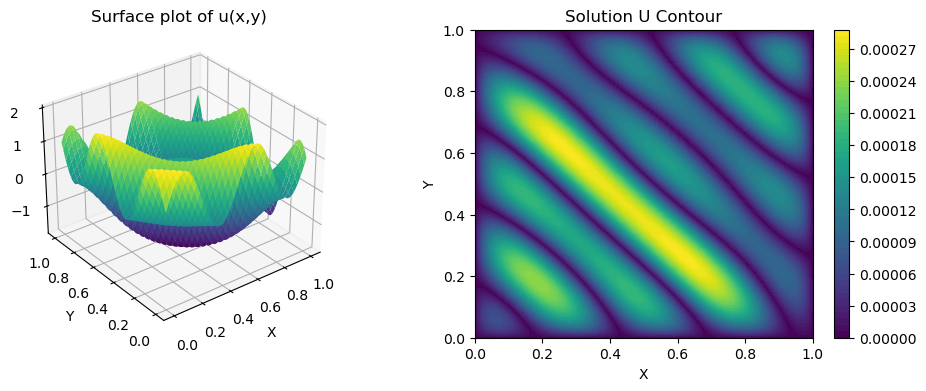

In [127]:
# Create figure with 2 columns
fig = plt.figure(figsize=(12, 4), dpi=100)
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1],wspace=0.2)

# ----- Subplot 1: 3D Surface Plot -----
ax1 = fig.add_subplot(gs[0], projection='3d')
ax1.plot_surface(X, Y, U, cmap='viridis')

# Reverse axes for MATLAB-like orientation
ax1.set_xlim(ax1.get_xlim()[::-1])  
ax1.set_ylim(ax1.get_ylim()[::-1])  

# Set view to match MATLAB
ax1.view_init(elev=30, azim=90-37.5)

# Labels
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('u(X,Y)')
ax1.set_title('Surface plot of u(x,y)')

# ----- Subplot 2: Contour Plot -----
ax2 = fig.add_subplot(gs[1])
contour = ax2.contourf(X, Y, error, levels=50, cmap='viridis')
fig.colorbar(contour, ax=ax2)  # Add colorbar
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('Solution U Contour')

plt.show()

Let's plot the outer iterations for different values of m

Text(0.5, 1.0, 'Outer Iterations vs m')

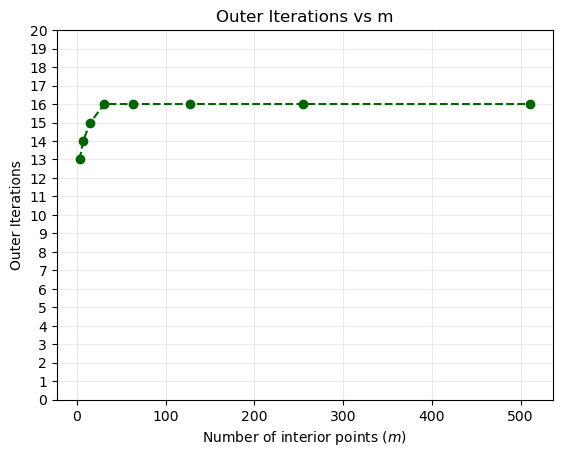

In [137]:
# Mesh
# k_values = [2,3,4,5,6,7,8,9,10,11,12]
k_values = [2,3,4,5,6,7,8,9]
m_values = [2**k-1 for k in k_values]
outer_iterations_counts = []

for m in m_values:
    h = 1 / (m + 1)
    x = np.linspace(0, 1, m+2)
    y = np.linspace(0, 1, m+2)

    X, Y = np.meshgrid(x, y)

    # Compute exact solution and Laplacian
    u_exact = exact_solution(X, Y)
    exact_laplacian = analytical_laplacian(X, Y)

    # Construct right-hand side (vectorized)
    f = exact_laplacian.copy()

    # Extract only the interior points
    f_complete = f_BC_5p(f,u_exact) 
    f = f_complete[1:-1, 1:-1]

    # Flatten to match dimensionality
    f_flatten = f.flatten('F')

    # Solve system
    u_app = np.zeros(m**2)  # Initial guess

    # Vcycle
    # u_app = Vcycle(u_app, 2/3, 10, m, f_flatten)
    u_app, i = outer_iteration(u_app, m, f_flatten)

    outer_iterations_counts.append(i)

plt.figure()
plt.plot(m_values, outer_iterations_counts,'--o', color='darkgreen')
plt.xlabel(r'Number of interior points $(m)$')
# plt.xscale('log')
plt.ylim([0,20])
plt.yticks(np.arange(0, 21, 1))
plt.ylabel('Outer Iterations')
plt.grid(True, which='both', alpha=.25)
plt.title('Outer Iterations vs m')